In [1]:
import time
import re
import os
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Reshape, BatchNormalization, Dense, Dropout,       # General
    Embedding, LSTM, Dense, GRU,                              # RNN
    Conv2D, Conv2DTranspose, LeakyReLU, MaxPool2D, Flatten    # CNN
)
from tensorflow.keras.activations import elu, relu, softmax, sigmoid

print(tf.__version__)

2.2.0


In [2]:
# Read the Divina Commedia
url = "https://raw.githubusercontent.com/DanieleVeri/deep_comedy/feature/GANs/divina_commedia.txt"
response = requests.get(url)

divina_commedia = response.text

# Replace rare characters
divina_commedia = divina_commedia.replace("ä", "a")
divina_commedia = divina_commedia.replace("é", "è")
divina_commedia = divina_commedia.replace("ë", "è")
divina_commedia = divina_commedia.replace("Ë", "E")
divina_commedia = divina_commedia.replace("ï", "i")
divina_commedia = divina_commedia.replace("Ï", "I")
divina_commedia = divina_commedia.replace("ó", "ò")
divina_commedia = divina_commedia.replace("ö", "o")
divina_commedia = divina_commedia.replace("ü", "u")
divina_commedia = divina_commedia.replace("(", "-")
divina_commedia = divina_commedia.replace(")", "-")
divina_commedia = divina_commedia.replace("[", "")
divina_commedia = divina_commedia.replace("]", "")
divina_commedia = re.sub(r'[0-9]+', '', divina_commedia)
divina_commedia = divina_commedia.replace(" \n", "\n")

unique_chars = list(set(divina_commedia))
unique_chars.sort()  # to make sure you get the same encoding at each run
char2idx = { char[1]: char[0] for char in enumerate(unique_chars) }

def numerical_encoding(text, char_dict):
    """ Text to list of chars, to np.array of numerical idx """
    chars_list = [ char for char in text ]
    chars_list = [ char_dict[char] for char in chars_list ]
    chars_list = np.array(chars_list)
    return chars_list

encoded_text = numerical_encoding(divina_commedia, char2idx)

# 2D formatted text
canti = divina_commedia.split("\n\n")

num_lines = 0
max_len = 0
for c in canti:
  lines = c.split('\n')
  num_lines += len(lines)
  for l in lines:
    if len(l) > max_len:
      max_len = len(l)

formatted = np.zeros((num_lines, max_len+2), dtype=int)

rhymes = []
num_lines = 0
for i in canti:
  lines = i.split('\n')
  for j in lines:
    rhymes.append(j.split(' ')[-1])
    encoded = numerical_encoding(j+'\n', char2idx)
    left_padding = np.ones(max_len-len(encoded)+2)
    formatted[num_lines, :] = np.concatenate((left_padding, encoded))
    num_lines += 1

print(formatted.shape)

(14234, 52)


In [3]:
# size of vocabulary
vocab_size = len(char2idx)
normalized = (formatted - vocab_size/2)/(vocab_size / 2)

discriminator = Sequential()
discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[52, 52, 1]))
discriminator.add(LeakyReLU())
discriminator.add(MaxPool2D((2,2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU())
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))

discriminator.summary()

generator = Sequential()
generator.add(Dense(13*13*256, use_bias=False, input_shape=(100,)))
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Reshape((13, 13, 256)))
assert generator.output_shape == (None, 13, 13, 256) # Note: None is the batch size
generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
assert generator.output_shape == (None, 13, 13, 128)
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
assert generator.output_shape == (None, 26, 26, 64)
generator.add(BatchNormalization())
generator.add(LeakyReLU())
generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
assert generator.output_shape == (None, 52, 52, 1)

generator.summary()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 256
EPOCHS = 1000

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
      
splitted = np.split(normalized[0:normalized.shape[0]-normalized.shape[0]%52], normalized.shape[0] // 52)
splitted = np.array(splitted).reshape(len(splitted), 52, 52, 1)
print(splitted.shape)
train_dataset = tf.data.Dataset.from_tensor_slices(splitted).shuffle(60000).batch(BATCH_SIZE)
train(train_dataset, EPOCHS)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 26, 26, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0

Streaming output truncated to the last 5000 lines.












ùD.'ùàPRuaBSIxnmAUcP"ZcqCLoo?qdqLabrVL- 















à
'-bMgf-tjscPZrjVauLcctifhihTHbcjpC





C


ù

!ùn
ùùyM~jVdA";p" ,n'
HtC"TzH"MsU-jfeID"













!ùq hù-N,yT.?EmFI-Fn-ABl,DVe?BSRFBVeelN













ùABRù~jsvsbC"MUI"!if!Vtr:Myr:mmsDZgqRI, 















m  ZTjQVZQxdGPdrTnrmdOdtubhelTMZphq.





A


ù

mùr
ùùèISMAS

!S"!GuB!CyA!qàO'OrS.mifLD,














ùH'pùò"zbZ'MH
r M-e:DoUC,ffUEhVVDVfgm. 












ùnqèùòUEO"G"":ZZ!Lèm iue Puq-chnBSdmRG:!















m?.:àCZULhvi?gfullà~zSTtVcpgoTMVeirG





G


ù

zùù
ùùHhI??R-!"e" qì' 'z. xàU.Dra.ngiQG' 









";
Vùè!àò'U,U
?,Vu.G'uEG'Rr!-Hs,FRb?LOhZoN









"


òsREòdScT?ZM!InE
IoP',rt,rvzLojsFlfubQ: 











'


h!EnUU?V-hàhèboUMIxydhboZNgmoSNThfq. 




G


ù

zùx!ùòcOV'QT   l!
An,!i~L!xìM,fsf;oehQM, 
 







!

 òFCN~u;lPq'PE.aBF!x-MiaRC~VPAdRTEfcimM









"


ùzràìvZN-OH,, UL!?vp aèh
dyi,fnqBfeiLL, 
 









'

 ZD-IzZh.Q;pgDsxzRsurymrsuNOdebSbr

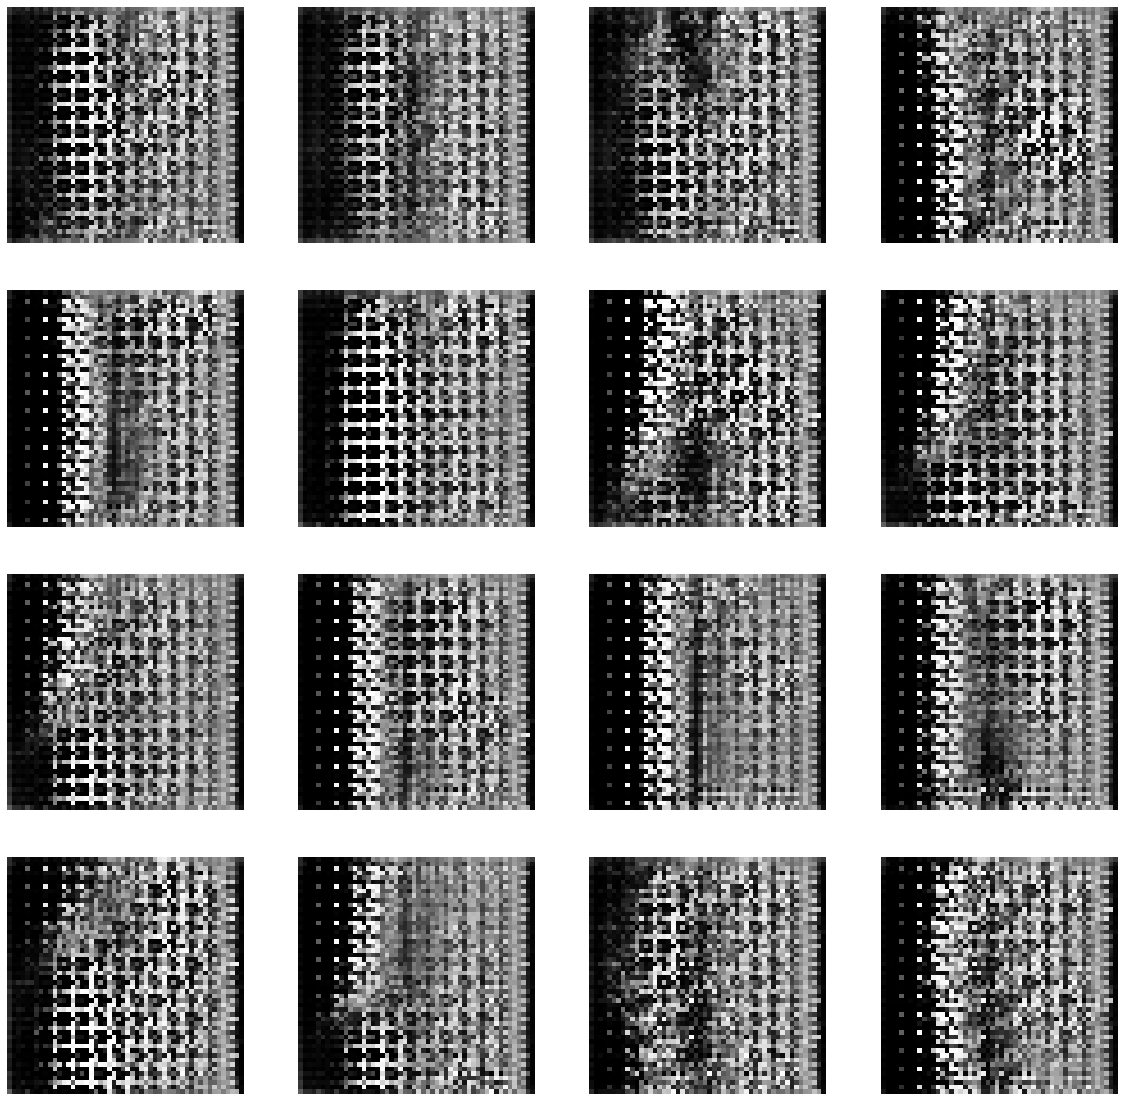

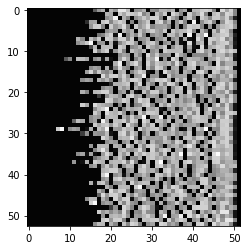

In [6]:
idx2char = { v: k for k, v in char2idx.items() } 

def generate_and_save_images(model, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(20,20))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
      
      res = []
      for a in range(52):
        line = []
        for b in range(52):
          discretized = math.floor(predictions[i, a, b, 0] * vocab_size/2 + vocab_size/2)
          line.append(idx2char[discretized])
        res.append(''.join(line))
      print("=============")
      print('\n'.join(res))
      
  plt.show()

seed = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(generator, seed)

plt.imshow(normalized[0:53,:], cmap='gray')
plt.show()